### Install

In [336]:
#pip install ucimlrepo

### Imports

In [337]:
# Imports
from ucimlrepo import fetch_ucirepo
import pandas as pd
import psycopg2
from collections import defaultdict
from scipy import stats as kl
from decimal import Decimal
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from itertools import product


In [338]:
# connection = psycopg2.connect(database="Project645", user="vaishnavishah", password="10jan2001", host="localhost", port=5432)
connection = psycopg2.connect(database="Project645", user="postgres", password="Rajada1234@", host="localhost", port=5433)
#connection = psycopg2.connect(database="seedb", user="postgres", password="nineten910", host="localhost", port=5432)
cursor = connection.cursor()


In [339]:
# checking execution
query = "select workclass from married limit 5;"

cursor.execute(query)
record = cursor.fetchall()
print(record)

[('Self-emp-not-inc',), ('Private',), ('Private',), ('Private',), ('Private',)]


In [340]:
aggregation_functions = ['avg', 'sum', 'max', 'min', 'count']
group_by_columns = [
    'workclass',
    'education',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native_country',
    'income'
]
measure_columns = [
    'age',
    'fnlwgt',
    'education_num',
    'capital_gain',
    'capital_loss',
    'hours_per_week'
]

In [341]:
# FORMULAS 

# min_fl = np.finfo(float).eps
# def kl_distance(target, reference):
#     # print('Target ',target)
#     # print('Ref ',reference)
#     target = dict(target)
#     reference = dict(reference)

#     t = list()
#     r = list()

#     # we need this because this ensures that there are the same number of categories in each distribution
#     for key in set().union(target.keys(), reference.keys()):
#         t_val = float(target.get(key, 0))
#         r_val = float(reference.get(key, 0))
#         t.append(t_val)
#         r.append(r_val)


#     # normalize to create a probability distribution
#     t = np.asarray(t) / (np.sum(t) or 1.0)
#     r = np.asarray(r) / (np.sum(r) or 1.0)
#     t = [max(x, min_fl) for x in t]
#     r = [max(x, min_fl) for x in r]


#     return entropy(t, r)

min_fl = np.finfo(float).eps

def kl_distance(target, reference):
    target = dict(target)
    reference = dict(reference)

    t = []
    r = []

    # We need this to ensure the same number of categories in each distribution
    for key in set().union(target.keys(), reference.keys()):
        t_val = float(target.get(key, 0))
        r_val = float(reference.get(key, 0))
        t.append(t_val)
        r.append(r_val)

    # Normalize to create a probability distribution
    t_sum = np.sum(t) or 1.0
    r_sum = np.sum(r) or 1.0
    t = np.asarray(t) / t_sum
    r = np.asarray(r) / r_sum
    t = np.maximum(t, min_fl)
    r = np.maximum(r, min_fl)

    entropy_cal = np.sum(t * np.log(t / r))

    return entropy_cal

def hoeffding_serfling_interval(phase, num_phases, delta):
    phase = float(phase)
    num_phases = float(phase)
    numerator = (1 - ((phase - 1) / num_phases)) * (2 * np.log(np.log(phase)) + np.log((np.pi * np.pi) / (3 * delta)))
    epsilon_m = np.sqrt(numerator / (2 * phase))
    return epsilon_m

In [342]:
# age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country

In [343]:
def calculate_top_k(cur, views_ls, top_k=5, verbose=False):
    results = list()
    query = "select {group}, {func}({m_col}) from {table} {where} group by {group};"
    for group, views in views_ls.items():
        for view in views:
            _, func, m_col = view
            target_query = query.format(group=group,
                                        func=func,
                                        m_col=m_col,
                                        table='married',
                                        where=""
                                        )

            cur.execute(target_query)
            target_results = cur.fetchall()

            reference_query = query.format(group=group,
                                           func=func,
                                           m_col=m_col,
                                           table='unmarried',
                                           where=""
                                           )
            cur.execute(reference_query)
            reference_results = cur.fetchall()
            #print('target ', target_results)
            #print('ref: ', reference_results)
            tmp_query = """
            SELECT COALESCE(t.{group}, r.{group}) AS {group},
                COALESCE(t.target_{func}_{m_col}, 0) AS target_{func}_{m_col},
                COALESCE(r.reference_{func}_{m_col}, 0) AS reference_{func}_{m_col}
            FROM (
                -- Target results
                SELECT {group}, {func}({m_col}) AS target_{func}_{m_col}
                FROM married
                GROUP BY {group}
            ) AS t
            INNER JOIN (
                -- Reference results
                SELECT {group}, {func}({m_col}) AS reference_{func}_{m_col}
                FROM {table_reference}
                GROUP BY {group}
            ) AS r ON t.{group} = r.{group};
            """.format(
                group=group,
                func=func,
                m_col=m_col,
                where_target='',  
                table_reference='unmarried',
            )
            #print('combiend ', tmp_query)
            cur.execute(tmp_query)
            combined_results = cur.fetchall()
            #print(combined_results)
            target_results = [(group, target_measure) for group, target_measure, _ in combined_results]
            reference_results = [(group, ref_measure) for group, _, ref_measure in combined_results]

            #print('target ',target_results)
            #print('ref ',reference_results)
            dist = kl_distance(target_results, reference_results)
            #print(dist)
            results.append((view, dist))
            #print(results)
            if verbose:
                print ("{}, {}, {}".format(group, func, m_col), dist)
    return list(reversed(sorted(results, key=lambda x: x[1])))[:top_k]

In [344]:
def naive_search(cur, views_ls, top_k=5, verbose=False):

    grouped_views = defaultdict(list)

    for view in views_ls:
        grouper = view[0]
        grouped_views[grouper].append(view)

    
    return calculate_top_k(cur, grouped_views, top_k, verbose)


In [345]:
# views_ls = []
# for a in group_by_columns:
#     for f in aggregation_functions:
#         for m in measure_columns:
#             views_ls.append((a,f,m))
# naive_search(cursor, views_ls, 5)

In [346]:
def sharing_based_search(cur, views_ls, top_k=5, verbose=False):

    grouped_views = defaultdict(list)

    for view in views_ls:
        grouper = view[0]
        grouped_views[grouper].append(view)

    return calculate_top_k(cur, grouped_views, top_k, verbose)

In [347]:
def pruning_based_search(cur, views, top_k=5, verbose=False):
    mean_utils = {}

    for view, utility in sharing_based_search(cur, views, top_k=None):
        mean_utils[view] = (mean_utils.get(view, 0) + utility) / 2

    sorted_utils = sorted(mean_utils.values())
    max_utility = sorted_utils[-1]
    kth_utility = sorted_utils[-top_k] / max_utility

    for i in range(len(views)):
        if i == 0:
            if verbose:
                print("No pruning on the first iteration due to NaN epsilon.")
            continue

        epsilon = hoeffding_serfling_interval(i + 1, len(views), 0.1) 

        not_pruned_views = [v for v in views if (mean_utils[v] / max_utility + epsilon) >= (kth_utility - epsilon)]
        if verbose:
            print("Iteration %d: Pruned %d views." % (i, len(views) - len(not_pruned_views)))

        views = not_pruned_views[:]

    if verbose:
        print("Finished with %d views." % len(views))

    return sharing_based_search(cur, views, top_k, verbose)


In [348]:
# views_ls = []
# for a in group_by_columns:
#     for f in aggregation_functions:
#         for m in measure_columns:
#             views_ls.append((a,f,m))


# top_5_prun = pruning_based_search(cursor, views_ls,verbose=True)
# top_5_prun

In [349]:
# views_ls = []
# for a in group_by_columns:
#     for f in aggregation_functions:
#         for m in measure_columns:
#             views_ls.append((a,f,m))
# top_5_shar = sharing_based_search(cursor, views_ls, verbose=False)
# top_5_shar

In [350]:
import numpy as np
import matplotlib.pyplot as plt

def visualise(view, names, utility):
    num_categories = len(names)
    width = 0.4  # Adjust the width of the bars
    gap = 0.04  # Adjust the gap between bars

    fig, ax = plt.subplots(figsize=(15, 6))  # Adjust the figure size

    light_pink = '#FFB6C1'
    pastel_blue = '#AEC6CF'
    dark_pink = '#C71585'
    dark_blue = '#00008B'

    index = np.arange(num_categories)

    t_bar = ax.bar(index, t, width, color=light_pink, edgecolor=dark_pink)
    r_bar = ax.bar(index + width + gap, r, width, color=pastel_blue, edgecolor=dark_blue)

    ax.set_title("{f}({m}) Grouped by {g} (Measure = {measure}, Utility = {util})".format(f=view[1],
                                                                                          m=view[2],
                                                                                          g=view[0],
                                                                                          measure="KLD",
                                                                                          util=utility),
                 fontsize=16, color='navy')
    ax.set_ylabel("{f}({m})".format(f=view[1], m=view[2]), fontsize=14, color='black')  # Change y label color
    ax.set_xlabel("Categories of {g}".format(g=view[0]), fontsize=14, color='black')  # Change x label color

    ax.set_xticks(index + (width + gap) / 2)
    ax.set_xticklabels(names, fontsize=10, color='purple', rotation=60, ha='right')  # Rotate the x-axis tick labels

    ax.tick_params(axis='y', labelsize=10, colors='black')  # Change y tick label color

    ax.legend((t_bar[0], r_bar[0]), ('Married', 'Unmarried'), loc='upper right', fontsize=12)

    ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()


('native_country', 'avg', 'capital_loss') 11.928380269525338


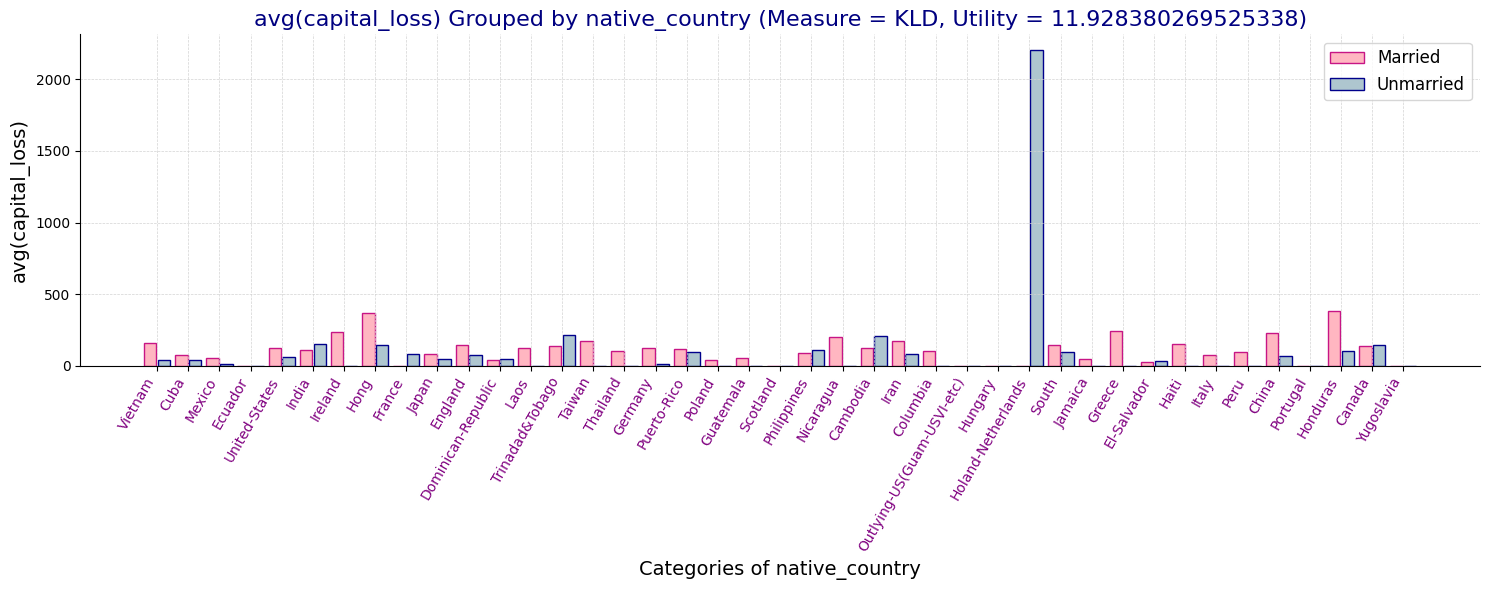

('native_country', 'max', 'capital_loss') 11.649641890739073


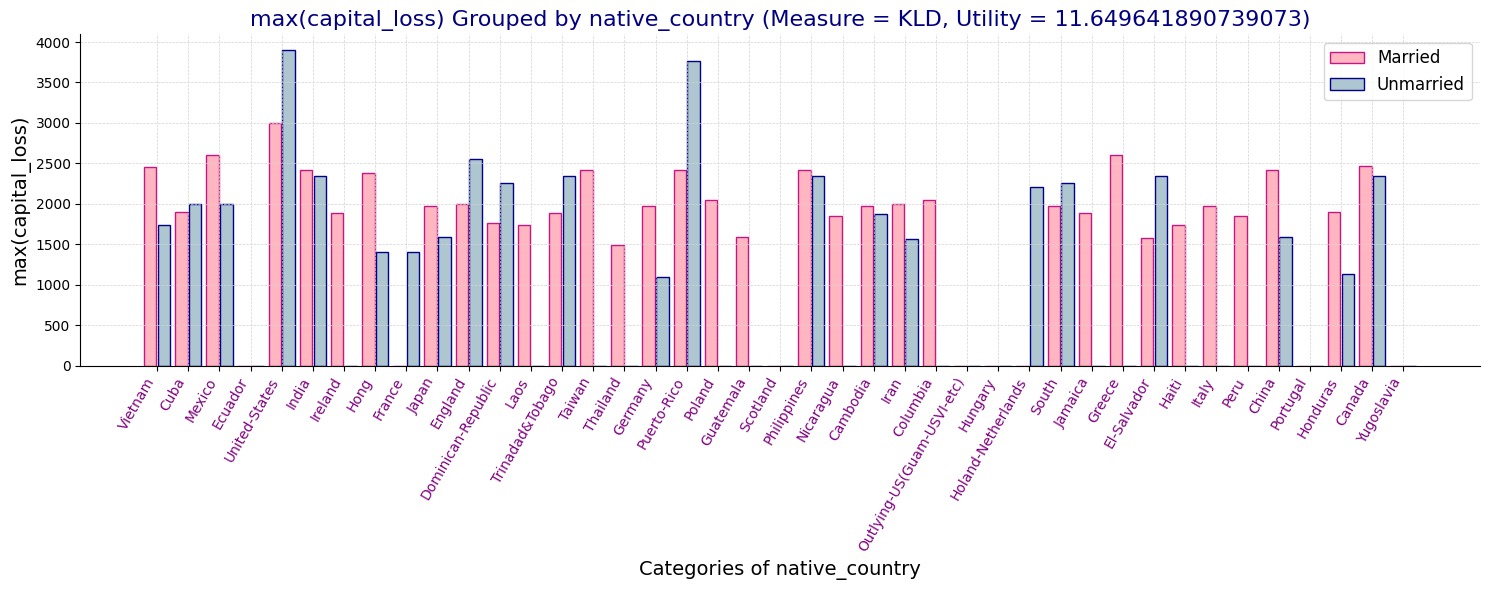

('native_country', 'avg', 'capital_gain') 7.367407353798934


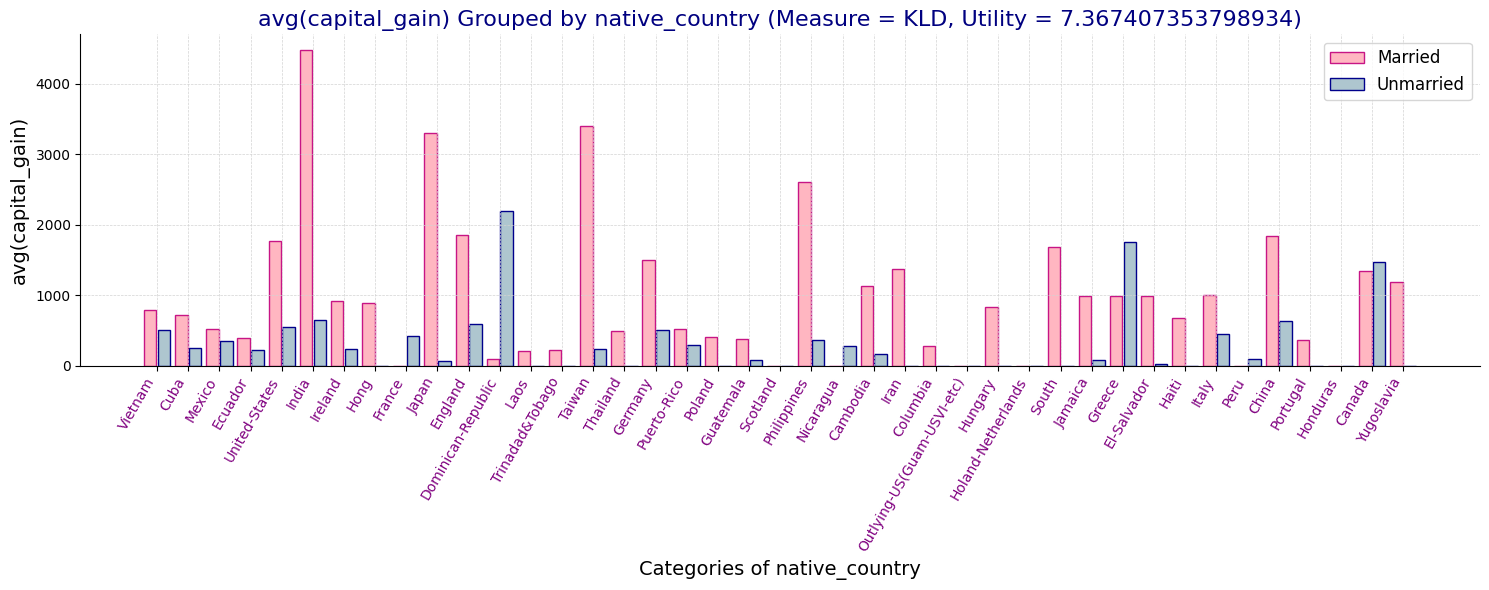

('occupation', 'avg', 'capital_loss') 6.518833732947606


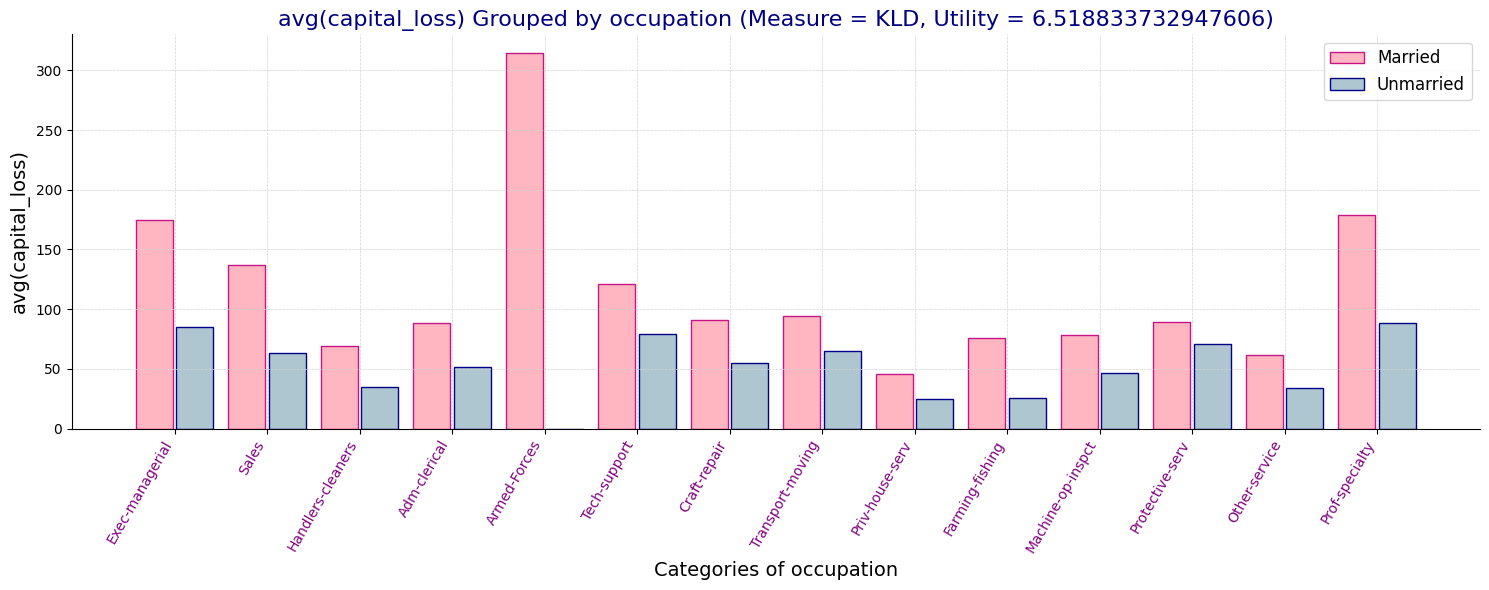

('workclass', 'avg', 'capital_loss') 4.891437460559656


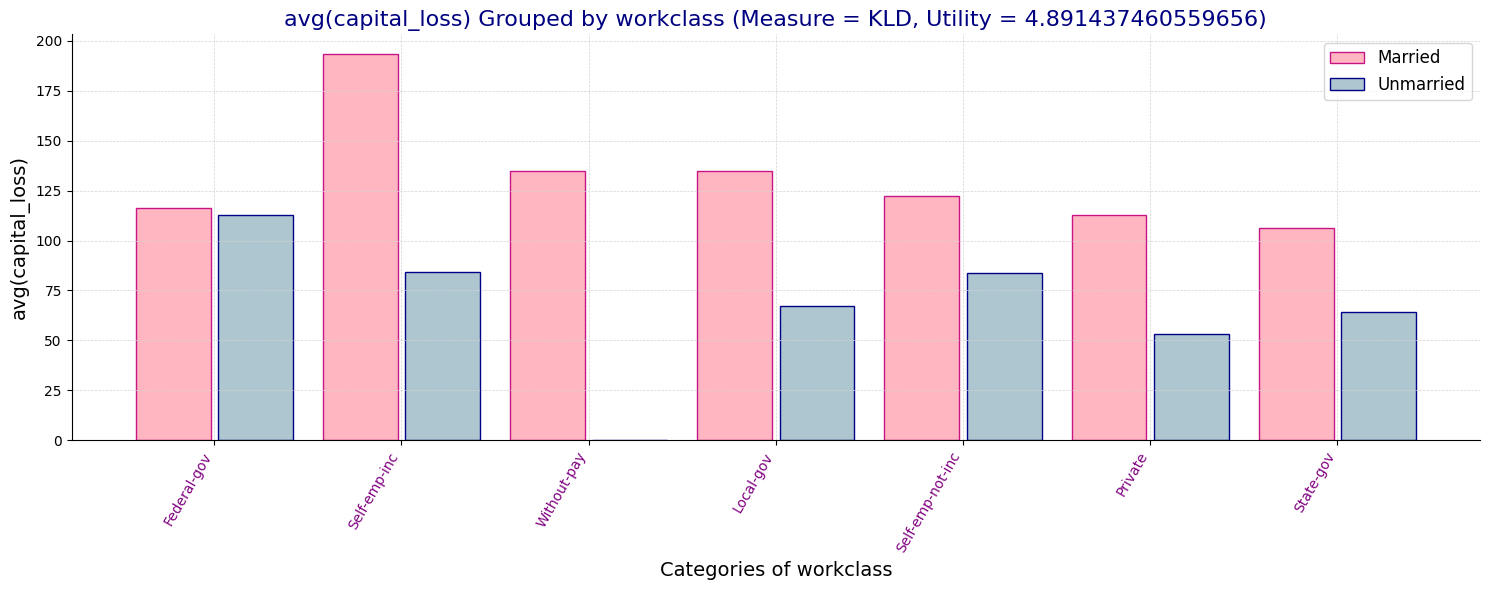

In [351]:
if __name__ == "__main__":

   
    views_ls = []
    for a in group_by_columns:
        for f in aggregation_functions:
            for m in measure_columns:
                views_ls.append((a,f,m))


    for i in range(1):
        # top_5 = pruning_based_search(cursor, views_ls,verbose=True)

        top_5 = sharing_based_search(cursor, views_ls, verbose=False)

    for view, utility in top_5:
        print (view, utility)

        cursor.execute("select {g}, {f}({m}) from married group by {g};".format(g=view[0], f=view[1], m=view[2]))
        target = dict(cursor.fetchall())

        cursor.execute("select {g}, {f}({m}) from unmarried group by {g};".format(g=view[0], f=view[1], m=view[2]))
        reference = dict(cursor.fetchall())

        t = list()
        r = list()
        names = list()

        for key in set().union(target.keys(), reference.keys()):
            names.append(key)
            t_val = float(target.get(key, 0))
            r_val = float(reference.get(key, 0))
            t.append(t_val)
            r.append(r_val)
        
        visualise(view, names, utility)

    connection.commit() 

In [352]:
cursor.close()
connection.close()

In [353]:
# age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country